In [1]:
pip install tensorflow_datasets

  Using cached tensorflow_datasets-4.4.0-py3-none-any.whl (4.0 MB)
  Using cached tensorflow_metadata-1.5.0-py3-none-any.whl (48 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached googleapis_common_protos-1.54.0-py2.py3-none-any.whl (207 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

  Using cached tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl (489.6 MB)
  Using cached h5py-3.6.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.1 MB)
  Using cached tensorflow_io_gcs_filesystem-0.23.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached grpcio-1.43.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.1 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached libclang-12.0.0-py2.py3-none-manylinux1_x86_64.whl (13.4 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sb


In [ ]:
# 

In [7]:
data,info=tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset=tfds.as_numpy(data)
n=np.array([x for x in dataset['train']])
t=np.array([x for x in dataset['test']])

print(n.shape,t.shape)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(3680,) (3669,)


# Train data for cats and dogs

In [8]:
cats,dogs=[],[]
for x in n:
    if x['species']==0:
        cats.append(x)
    else:
        dogs.append(x)


# Test data for cats and dogs

In [9]:
t_cats,t_dogs=[],[]
for x in t:
    if x['species']==0:
        t_cats.append(x)
    else:
        t_dogs.append(x)


In [59]:
# Taking first 25 images for training
image_number=25

# Train Dataset
d_x_train=np.array([tf.image.resize(x['image'],(128,128))for x in dogs[:image_number]])
d_y_train=np.array([tf.image.resize(x['segmentation_mask'],(128,128))for x in dogs[:image_number]])

c_x_train=np.array([tf.image.resize(x['image'],(128,128))for x in cats[:image_number]])
c_y_train=np.array([tf.image.resize(x['segmentation_mask'],(128,128))for x in cats[:image_number]])

# Test Dataset
d_x_test=np.array([tf.image.resize(x['image'],(128,128))for x in t_dogs[:image_number]])
d_y_test=np.array([tf.image.resize(x['segmentation_mask'],(128,128))for x in t_dogs[:image_number]])

c_x_test=np.array([tf.image.resize(x['image'],(128,128))for x in t_cats[:image_number]])
c_y_test=np.array([tf.image.resize(x['segmentation_mask'],(128,128))for x in t_cats[:image_number]])



c_y_train[c_y_train==3]=2
d_y_train[d_y_train==3]=2

c_y_test[c_y_test==3]=2
d_y_test[d_y_test==3]=2

# Reshaping elements in Cat dataset for training
cat_x=c_x_train.reshape([-1,3])
cat_y=(c_y_train.reshape([-1,])).astype(np.int16)

# Reshaping elements in Dog dataset for training
dog_x=d_x_train.reshape([-1,3])
dog_y=(d_y_train.reshape([-1,])).astype(np.int16)



# Cat image segmentation

In [12]:
from cuml import SVC
import cudf

clf_cat = SVC(kernel='rbf', gamma=0.001, C=1)
clf_cat.fit(cat_x, cat_y)

SVC()

## Saving trained model for future use

In [60]:
import pickle

filename = 'cat_image_segmentation_model.sav'
pickle.dump(clf_cat, open(filename, 'wb'))
 

### load the model from disk

# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

## Prediction on Train Data

In [14]:
pred = clf_cat.predict(c_x_train[0].reshape([-1,3]))
cat_seg_image = pred.reshape([128,128])
cat_seg_image

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int16)

## Train Data original image

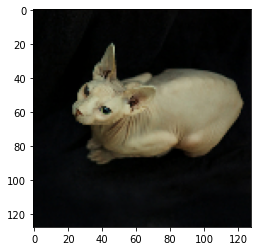

In [15]:
plt.imshow(c_x_train[0].astype(np.uint8))
plt.show()

## Given Train data  segmented mask

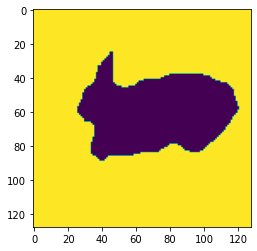

In [19]:
plt.imshow(c_y_train[0].astype(np.uint8))
plt.show()

## Predicted segment mask by clf_cat

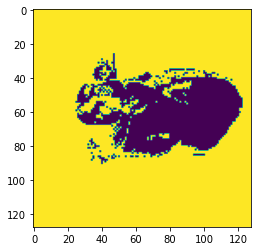

array([1, 2], dtype=int16)

In [17]:
plt.imshow(cat_seg_image)
plt.show()
np.unique(cat_seg_image)

## Prediction on Test Data

In [21]:
pred_test_cat = clf_cat.predict(c_x_test[2].reshape([-1,3]))
t_cat_seg_image = pred_test_cat.reshape([128,128])
t_cat_seg_image

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int16)

## Test Data original image

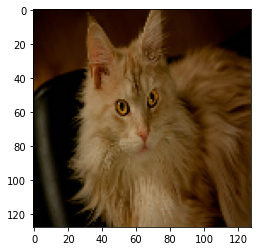

In [20]:
plt.imshow(c_x_test[2].astype(np.uint8))
plt.show()

## Given Test data  segmented mask

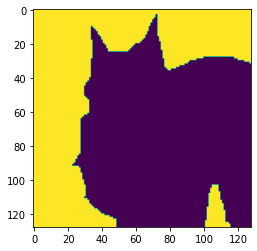

In [22]:
plt.imshow(c_y_test[2].astype(np.uint8))
plt.show()

## Predicted segment mask by clf_cat

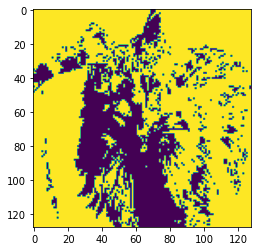

array([1, 2], dtype=int16)

In [23]:
plt.imshow(t_cat_seg_image)
plt.show()
np.unique(t_cat_seg_image)

# Dog image segmentation

In [24]:
from cuml import SVC
import cudf

clf_dog = SVC(kernel='rbf', gamma=0.001, C=1)
clf_dog.fit(dog_x, dog_y)

SVC()

In [61]:
import pickle

filename = 'dog_image_segmentation_model.sav'
pickle.dump(clf_dog, open(filename, 'wb'))

### load the model from disk

# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

## Prediction on Train Data

In [26]:
pred = clf_dog.predict(d_x_train[1].reshape([-1,3]))
dog_seg_image = pred.reshape([128,128])
dog_seg_image

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int16)

## Train Data original image

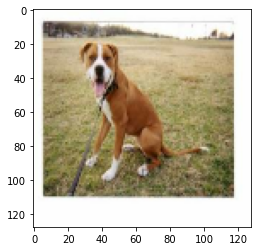

In [110]:
plt.imshow(d_x_train[1].astype(np.uint8))
plt.show()

## Given Train data  segmented mask

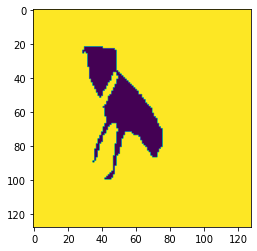

In [25]:
plt.imshow(d_y_train[1].astype(np.uint8))
plt.show()

## Predicted segment mask by clf_dog

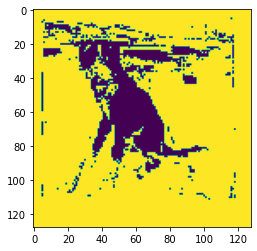

array([1, 2], dtype=int16)

In [27]:
plt.imshow(dog_seg_image)
plt.show()
np.unique(dog_seg_image)

## Prediction on Test Data

In [56]:
pred_test_dog = clf_dog.predict(d_x_test[15].reshape([-1,3]))
t_dog_seg_image = pred_test_dog.reshape([128,128])
t_dog_seg_image

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int16)

## Test Data original image

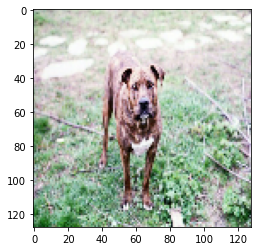

In [52]:
plt.imshow(d_x_test[15].astype(np.uint8))
plt.show()

## Given Test data  segmented mask

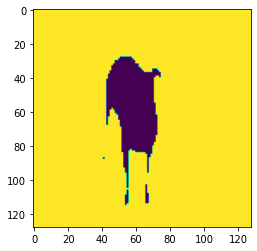

In [58]:
plt.imshow(d_y_test[15].astype(np.uint8))
plt.show()

## Predicted segment mask by clf_dog

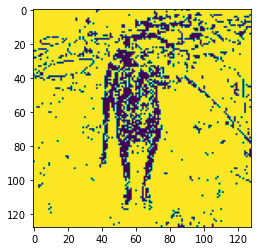

array([1, 2], dtype=int16)

In [57]:
plt.imshow(t_dog_seg_image)
plt.show()
np.unique(t_dog_seg_image)